In [1]:
import os
import numpy as np
import glob
import scipy.stats as st
import math
import matplotlib.pyplot as plt
import cv2
import video_detection as vd
import json

<h2>Gráfico de tempo</h2>

In [2]:
colors = np.random.rand(3,3)

avgs [0.09821249 0.08828067 0.14013955]
errors [1.16454173e-05 8.00468778e-06 1.39549047e-05]
[0.09820084 0.08827267 0.1401256 ]
[[0.84998755 0.06435828 0.26726912]
 [0.00119335 0.20760605 0.70958512]
 [0.84798141 0.05067655 0.09866817]]


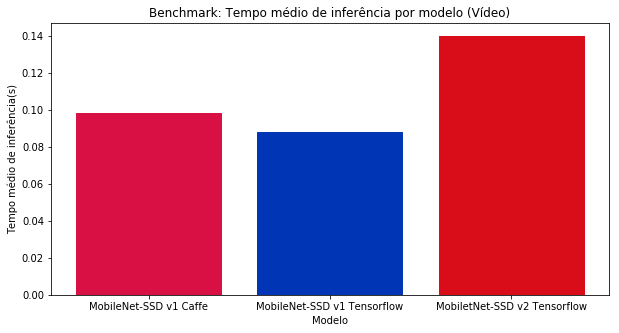

In [3]:
models = []
models.append({'id': 1, 'name':'MobileNet-SSD v1 Tutorial', 'display_name': 'MobileNet-SSD v1 Caffe'})
models.append({'id': 2, 'name':'MobileNet-SSD v1 Coco', 'display_name': 'MobileNet-SSD v1 Tensorflow'})
models.append({'id': 3, 'name':'MobileNet-SSD v2 Coco', 'display_name': 'MobiletNet-SSD v2 Tensorflow'})

def conf_inter(sample, interval):
    avg = np.average(sample)
    std = st.sem(sample)
    conf = st.norm.interval(interval, loc=np.average(sample), scale=st.sem(sample)/math.sqrt(len(sample)))
    return conf

def collect_metrics(files):
    files.sort()
    metrics = np.zeros(shape=(len(files), 4))

    for i, file in enumerate(files):
        with open(file,'r') as f:
            data = f.read()
            measurements = np.array(data.split('\n'))
            measurements = measurements[measurements != ''].astype(np.float32)
            avg = np.average(measurements)
            std = st.sem(measurements)
            conf = conf_inter(measurements, 0.95)
            metrics[i,:] = [avg, std, conf[0], conf[1]]
    return metrics


def plot_time_bars(models, averages, errors, title, file_name, colors=[]):
    names = [param['display_name'] for param in models]
    
    fig, axis = plt.subplots(1, 1, figsize=(10, 5))
    axis.set_title(title)
    axis.set_ylabel('Tempo médio de inferência(s)')
    axis.set_xlabel('Modelo')
    bars = axis.bar(names, averages, yerr=errors)
    if(not colors.any()):
        for bar in bars:
            color = np.random.rand(3)
            print(color)
            bar.set_color(color)
    else:
        for bar, color in zip(bars, colors):
            bar.set_color(color)

    if(os.path.exists(file_name)):
        os.remove(file_name)
        
    plt.savefig(file_name)
    
def unpack_metrics(metrics):
    averages = metrics[:,0]
    stds = metrics[:,1]
    errors = averages-metrics[:,2]
    return averages, stds, errors

test_name = 'dataset'

files = ['benchmark/time_{}_{}.dat'.format(param['name'], 'video_file') for param in models]
metrics = collect_metrics(files)
#averages = metrics[:,0]
#stds = metrics[:, 1]
#errors = averages-metrics[:,2]
video_averages, video_stds, video_errors = unpack_metrics(metrics)
#print('metrics', metrics)
print('avgs', video_averages)
#print('stds', stds)
print('errors', video_errors)
print(video_averages-video_errors)
print(colors)
title = 'Benchmark: Tempo médio de inferência por modelo (Vídeo)'
plot_time_bars(models, video_averages, video_errors, title, 'charts/time_bar_video.png', colors)



[0.09423725 0.0817614  0.13956995]


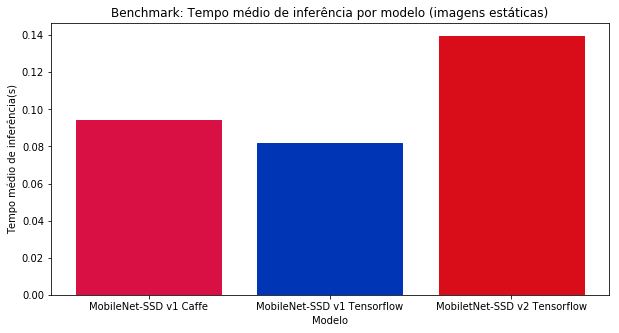

In [4]:
files=['benchmark/time_{}_{}.dat'.format(param['name'], 'dataset') for param in models]
metrics = collect_metrics(files)
#averages = metrics[:,0]
#stds = metrics[:, 1]
#errors = averages-metrics[:,2]
image_averages, image_stds, image_errors = unpack_metrics(metrics)
print(image_averages)
title = 'Benchmark: Tempo médio de inferência por modelo (imagens estáticas)'
plot_time_bars(models, image_averages, image_errors, title, 'charts/time_bar_static.png',colors)

In [5]:
for model in models:
    file_name = 'benchmark/coco_{}_{}.dat'.format(model['name'], test_name)
    with open(file_name, 'r') as file:
        content = file.read()
        test_results = np.array(content.split('\n'))
        test_results = test_results[test_results != ''].astype(np.float32)
        model['results'] = test_results
        #print('resultado do {}\n'.format(model['name']), content)
        print('test results', test_results)

test results [0.00557092 0.00767817 0.0060761  0.         0.00159993 0.01226696
 0.00577825 0.00630042 0.00630042 0.         0.00192573 0.01420568]
test results [0.24433659 0.3794046  0.264335   0.02167091 0.18894424 0.54502773
 0.21936043 0.28558776 0.28794152 0.02917853 0.22897877 0.6347224 ]
test results [0.259436   0.40251303 0.2804932  0.02540032 0.19832845 0.58263963
 0.23095174 0.29825678 0.30083027 0.03526387 0.24144188 0.6614456 ]


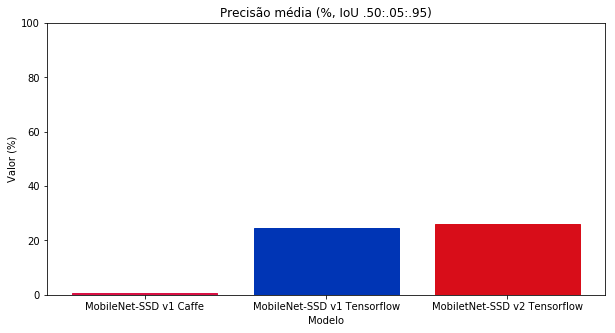

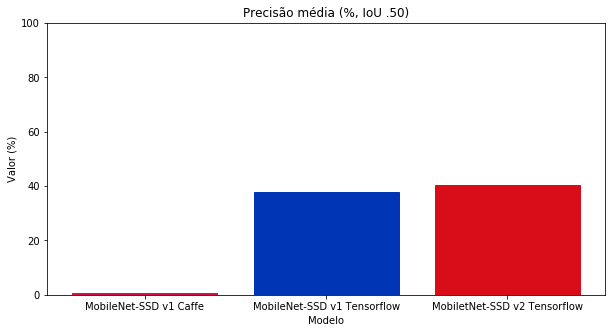

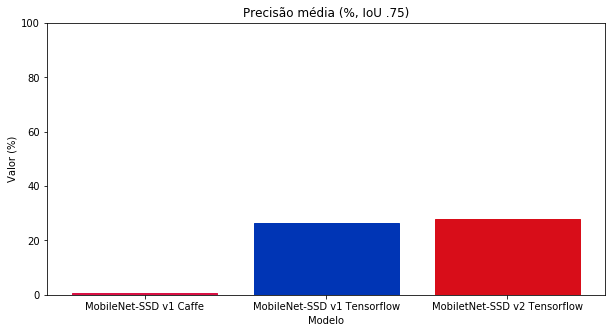

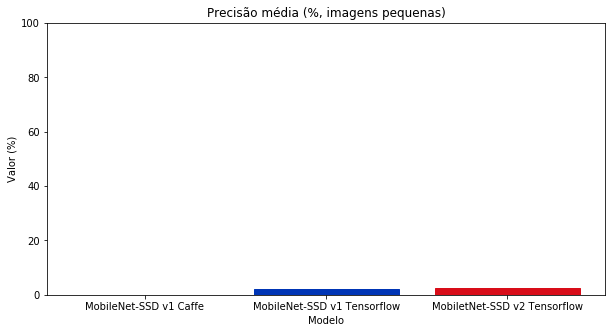

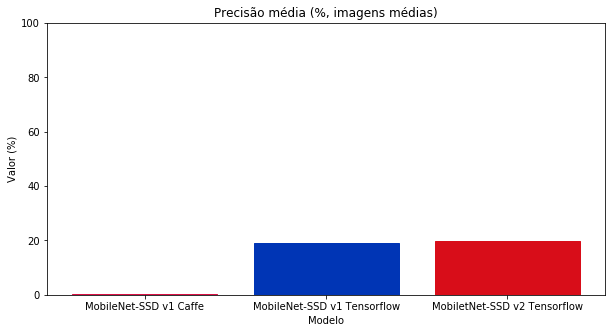

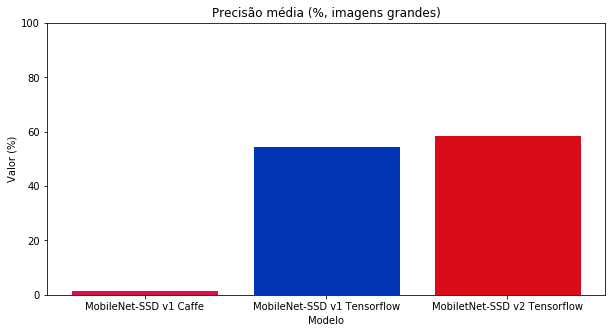

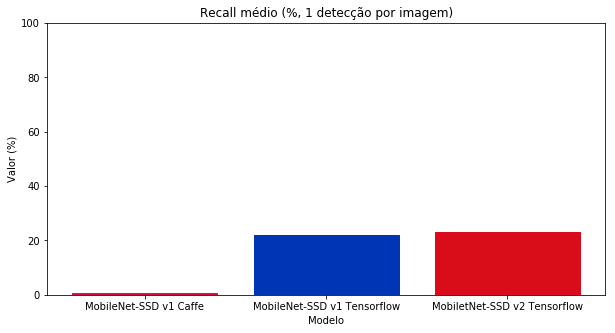

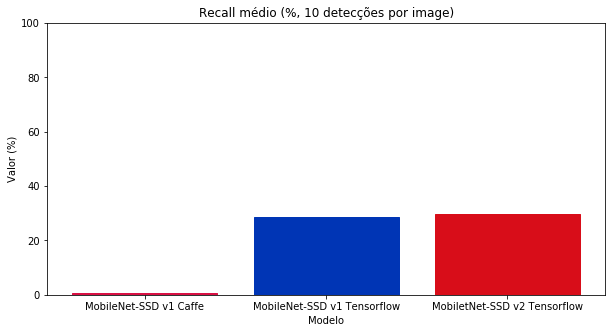

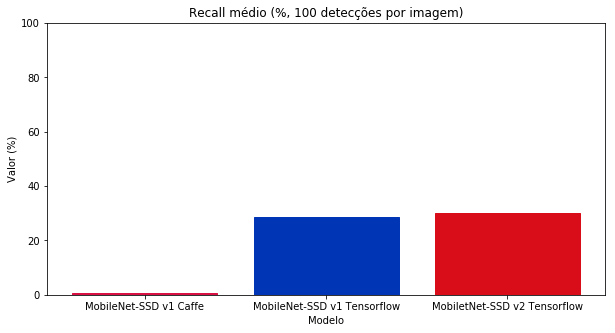

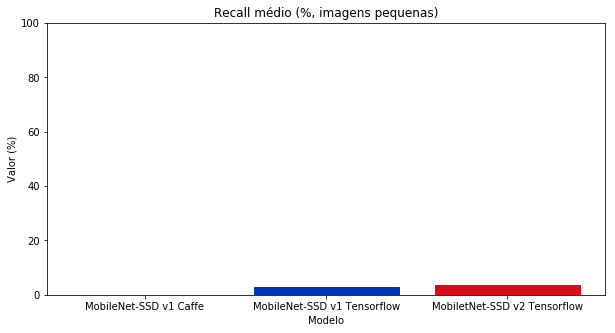

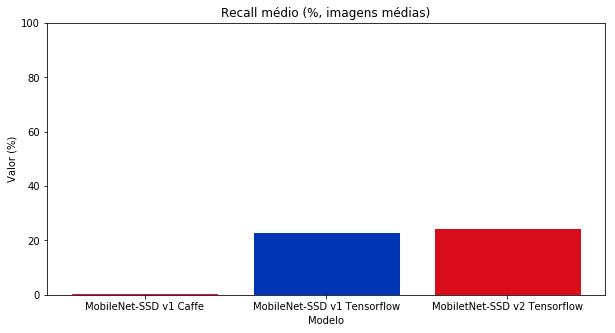

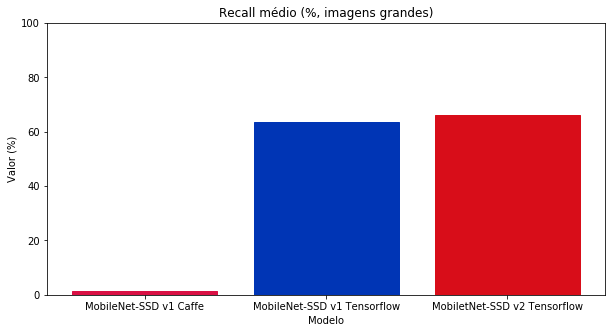

In [6]:
#print(models[0]['results'])
test_qtt = len(models[0]['results'])
#print(test_qtt)
results = np.zeros(shape=(test_qtt,len(models)), dtype=np.float32)

for test in range(test_qtt):
    for i, model in enumerate(models):
        results[test,i] = model['results'][test]

#print(results)
chart_names = ['Precisão média (%, IoU .50:.05:.95)','Precisão média (%, IoU .50)','Precisão média (%, IoU .75)']
chart_names.extend(['Precisão média (%, imagens pequenas)','Precisão média (%, imagens médias)','Precisão média (%, imagens grandes)'])
chart_names.extend(['Recall médio (%, 1 detecção por imagem)','Recall médio (%, 10 detecções por image)','Recall médio (%, 100 detecções por imagem)'])
chart_names.extend(['Recall médio (%, imagens pequenas)','Recall médio (%, imagens médias)','Recall médio (%, imagens grandes)'])
cur_file = 0
file_names = ['charts/ap_medio.png','charts/ap_medio_escala.png','charts/ar_medio.png','charts/ar_medio_escala.png']
#print(results)
model_names = [param['display_name'] for param in models]

for test in range(results.shape[0]):
    fig ,axis = plt.subplots(figsize=(10,5))
    axis.set_title(chart_names[test])
    axis.set_ylim(0.0, 100.0)
    axis.set_ylabel('Valor (%)')
    axis.set_xlabel('Modelo')
    #print('Colocando nas barras os valores', results[test]*100)
    bars = axis.bar(model_names, results[test]*100)
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    file_name = 'charts/{}.png'.format(chart_names[test])
    if(os.path.exists(file_name)):
        os.remove(file_name)
    plt.savefig(file_name)
    

['models/object-detection-deep-learning/mobnetssd1', 'models/object-detection-deep-learning/mobnetssd1_alt', 'models/object-detection-deep-learning/mobnetssd2']
[23.176917, 89.332987, 210.807761]


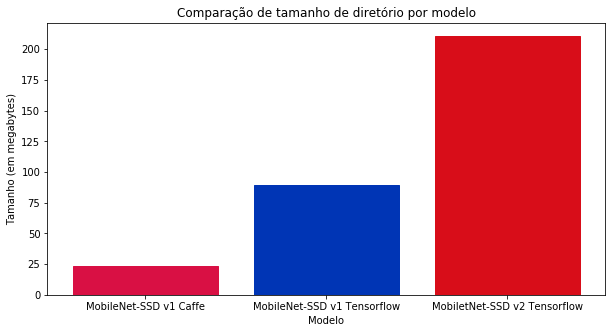

In [7]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

files = ['models/object-detection-deep-learning/{}'.format(file) for file in os.listdir('models/object-detection-deep-learning/')]
files.sort()
print(files)

sizes = [get_size(file)/1e6 for file in files]
print(sizes)

fig, axis = plt.subplots(figsize=(10,5))
axis.set_title('Comparação de tamanho de diretório por modelo')
axis.set_ylabel('Tamanho (em megabytes)')
axis.set_xlabel('Modelo')

bars = axis.bar(model_names, sizes)
for bar, color in zip(bars,colors):
    bar.set_color(color)
plt.savefig('charts/folder_size.png')

<h2>Tabelas</h2>

In [8]:
columns = ['MobiletNet-SSD v1. Caffe', 'MobileNet-SSD v1. Tensorflow', 'MobileNet-SSD v2. Tensorflow']
chart_names.insert(0, 'Tamanho(Mb)')
chart_names.insert(1, 'Tempo de inferência - Vídeos (s)')
chart_names.insert(2, 'Tempo de inferência - imgs. estáticas (s)')

In [9]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

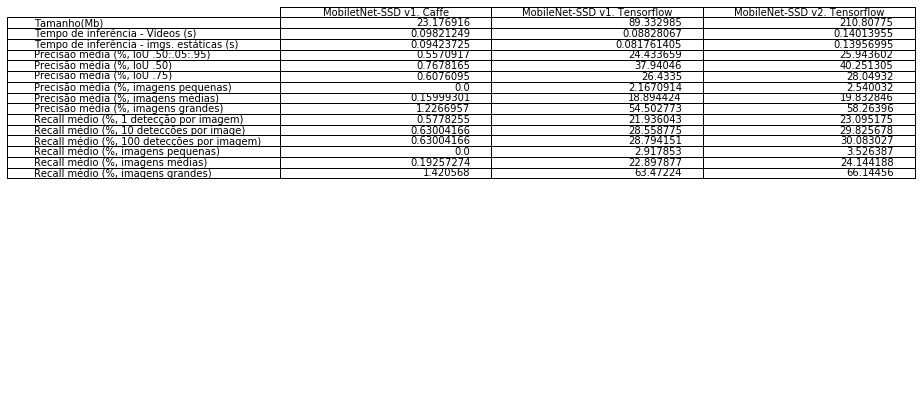

In [10]:
row_labels = chart_names
rows = np.ones(shape=(len(chart_names),len(columns)), dtype=np.float32)
rows[0,:] = sizes
rows[1,:] = video_averages
rows[2,:] = image_averages

#print(models)
#print('numero de testes', len(models[0]['results']))
test_num = len(models[0]['results'])
for i in range(0, test_num):
    for j, model in enumerate(models):
        #print(model['display_name'])
        rows[i+3, j] = model['results'][i]*100

fig, axis = plt.subplots(1,1)
#print(rows.shape)
table = axis.table(cellText=rows, rowLabels=chart_names,colLabels=columns, loc='top', colWidths=[0.7, 0.7, 0.7])
axis.axis('tight')
axis.axis('off')

plt.subplots_adjust(left=0.2, top=0.8)

In [11]:
row_labels = [chart for chart in chart_names]
row_labels = np.array(row_labels, dtype=np.str)
header = ['', 'MobileNet-SSD v1 Caffe', 'Mobilnet-SSD v1 TF', 'MobileNet-SSD v2 TF']
tab_header = ['',models[0]['display_name'],models[1]['display_name'],models[2]['display_name']]

#rounded_rows = np.round(rows, 3)
#print('original rows', rows)
#print('rounded rows', rounded_rows)
strfied_rows = []
formatter = lambda x: "%.3f" % x
strfied_rows.append([formatter(x) for x in rows[:,0]])
strfied_rows.append([formatter(x) for x in rows[:,1]])
strfied_rows.append([formatter(x) for x in rows[:,2]])
print(strfied_rows)

#print(row_values)
#print(rows.T)
data = [go.Table(
    header=dict(values=header, height=50),
    cells=dict(values=[row_labels, strfied_rows[0], strfied_rows[1], strfied_rows[2]], height=25, font=dict(size=15)),
    columnwidth=50,
)]

layout = go.Layout(
    width=900,
    height=1100,
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

#plotly.io.write_image(fig, 'charts/table.png')

[['23.177', '0.098', '0.094', '0.557', '0.768', '0.608', '0.000', '0.160', '1.227', '0.578', '0.630', '0.630', '0.000', '0.193', '1.421'], ['89.333', '0.088', '0.082', '24.434', '37.940', '26.434', '2.167', '18.894', '54.503', '21.936', '28.559', '28.794', '2.918', '22.898', '63.472'], ['210.808', '0.140', '0.140', '25.944', '40.251', '28.049', '2.540', '19.833', '58.264', '23.095', '29.826', '30.083', '3.526', '24.144', '66.145']]


Introdução

A expansão da utilização e poder computacional de dispositivos móveis, aliados à crescente demanda por aplicações sofisticadas destinadas a estas plataformas, provocou a ampliação do interesse em estudo e pesquisa em computação cognitiva. Como resultado, uma das maiores beneficiárias deste crescimento foi o campo científico de visão computacional, que encontrou uma variedade de usos na indústria e na eletrônica de consumo.E neste contexto, as últimas décadas resultaram em significativos avanços na disciplina, aproveitando-se sobretudo do progresso concomitante em inteligência artificial e aprendizado de máquina. Isto conferiu à visão computacional a flexibilidade proporcionada pelo uso de sistemas especialistas, sobretudo quando comparados com as tradicionais abordagens baseadas na detecção de formas paramétricas.

Desta forma, este trabalho foi concebido com o propósito de realizar a comparação quantitativa de modelos de aprendizado de máquina voltados à detecção de objetos em imagens. Houve interesse, sobretudo, em estudar a aplicabilidade destes modelos a circunstâncias que imponham limitações ao hardware utilizado, como em computadores pessoais de baixo custo.

Além disso, buscou-se estudar as métricas que são empregadas na avaliação da precisão de modelos de detecção de objetos na academia e na indústria. Isto foi feito com o intuito de providenciar informações dentro de um molde padrão que pode ser rapidamente compreendido pelo leitor, além de permitir a comparação dos resultados obtidos com referências fornecidas por trabalhos anteriores.

Metodologia

Para realização dos testes, foram selecionados modelos de visão computacional baseados em técnicas de Deep Learning, notórios por apresentar severas exigências de capacidade de processamento. Dada a intenção deste trabalho de explorar a viabilidade da tecnologia em plataformas de baixo desempenho, os modelos escolhidos deveriam se propor a atingir menor tempo de inferência. Neste estudo foram selecionados, portanto, os modelos MobileNet-SSD v1 e MobileNet-SSD v2, baseados nas arquiteturas SSD Faster-CNN (REVER), que empregam uma estrutura otimizada com a finalidade de reduzir a carga de processamento e, por consequência, obter menor tempo de inferência.

Também foi incluída nos testes uma comparação entre duas versões da MobileNet-SSD v1, implementadas em frameworks diferentes, a fim de permitir conclusões a respeito da variabilidade de qualidade e eficiência dos resultados que podem ser observados em diferentes implementações da mesma arquitetura. Busca-se realizar, então, uma deliberação a respeito da causas de eventuais diferenças observadas.

Os resultados obtidos são apresentados em 3 partes: comparação das dimensões físicas dos modelos, dos tempos de inferência e acurácia.

Primeiramente, a medição do tempo de inferência foi feita por meio do uso dos modelos, separadamente, na detecção de objetos sobre capturas de vídeo em tempo real e em detecção sobre imagens estáticas. No caso do vídeo, cada quadro é tratado como uma imagem independente, que é então submetida ao modelo de forma cronometrada. A medição é realizada 2000 vezes, seguida pelo cálculo da média com intervalo de confiança de 95%.

As medidas de tempo de inferência em imagens estáticas, assim como as medições da precisão de cada modelo, foram feitas empregando o dataset COCO (Common Objects in Context). Este é utilizado em pesquisas e competições que exploram o estado da arte em atividades de detecção de objetos, keypoints, captioning e segmentação. Para a realização deste trabalho, foi utilizado o dataset de validação para object detection de 2017. O conjunto COCO contem 5000 imagens anotadas, as quais consistem de objetos JSON, um para cada objeto de cada imagem, que segue o seguinte formato:

FORMATO DO JSON

Junto ao dataset, é fornecida pelos autores do conjunto de dados a ferramenta COCOeval, que utiliza a saída dos modelos (que deve ser disponibilizada no formato JSON, semelhante ao do ground truth) e realiza automaticamente a comparação das inferências com o ground truth do dataset. Esta resulta nas métricas sugeridas pelos autores do dataset, isto é, average precision (AP) e average recall (AR) utilizando intersection over union (IoU). O IoU consiste, essencialmente, em computar a razão com que as áreas do objeto detectado pela inferência da rede, e aquela esperada pelo ground truth se sobrepõem, resultando em um valor entre 0 e 1, que é mais alto quanto mais as duas imagens se sobrepõem.

O AP consiste no na média do número de predições realizadas corretamente sobre o número total de predições realizadas para cada classe. Já o AR representa o número médio de detecções que são realizados corretamente sobre o número de detecções que deveria ter sido realizado ao todo.

As métricas AP e AR são computadas, cada uma, em 6 testes: valor médio da métrica sobre todos os objetos, sendo que, para cada teste, um "acerto" é contabilizado se o valor de IoU estiver acima dado limite "threshold". Os primeiros testes de AP e AR realizam o cálculo de suas medidas sobre valores de IoU de 0.5 até 0.05, então de 0.5 até 0.095. O AP é aferido, ainda, 3 testes, em que a métrica é computada sobre objetos considerados pequenos (area < 32^2, em pixels), médios (32^2 < area < 96 ^2, em pixels) e grandes (96^2 < area, em pixels). O AP, enfim, é computado de mais 3 maneiras: considerando no máximo 1 detecção por imagem, 10 detecções por imagem e 100 detecções por imagem. O esquema de testes é ilustrado na tabela a seguir:

TABELA

A utilização dos modelos foi realizada por meio da interface na linguagem Python da biblioteca OpenCV. Isto se deve ao fato de oferecer um extenso conjunto de ferramentas de processamento de imagens e vídeos, eliminando atrasos com tarefas acessórias ao objetivo do trabalho. Adicionalmente, oferece acesso conveniente a funcionalidades que permitem o carregamento e uso de modelos criados e treinados em plataformas externas, como os supracitados Caffe e Tensorflow, por meio do módulo DNN, facilitando a criação de protótipos.

Resultados

Apresenta-se a seguir as informações a respeito das dimensões físicas de cada modelo em disco. Nota-se que os modelo s implementados em Tensorflow apresentam dimensões maiores.

Com relação ao tempo de inferência, é possível observar que o MobileNet-SSD v1 implementado em Tensorflow realiza inferências mais rapidamente do que a mesma versão do modelo implementada em Caffe, e que a segunda versão da MobileNet-SSD v2 sofreu uma perda de desempenho em comparação com a sua primeira versão. Outro fator notável é que a realização de detecção sobre captura de vídeo apresentou desempenho médio muito próximo daquele da detecção sobre imagens estáticas. Por fim,  o intervalo de confiança de 95% sobre a média do tempo de inferência nos dois testes apresenta valor tão baixo que é quase invisível nos gráficos, atestando a consistência e confiabilidade de que os modelos apresentarão desempenho similar ao observado nos testes.


<h2>Conclusão</h2>